### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import re
import os
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

### Scrape imdb website to find the top 250 movies

In [2]:
movie_list = []

def scrape_imdb_top_movies():
    """Scrape IMDB website, so we have a list of movies to analyze"""

    url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'

    response = requests.get(url, headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:130.0) Gecko/20100101 Firefox/130.0"})
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    content_script_tag = soup.find('script', type='application/ld+json')
    
    # Load JSON data
    json_data = json.loads(content_script_tag.string)
        
    movies = json_data['itemListElement']
    for movie in movies:
        name = movie['item']['name']
        genre = movie['item'].get('genre', 'N/A')  # Use .get() in case the field is missing
        description = movie['item'].get('description', 'N/A')
        duration = movie['item'].get('duration', 'N/A')
        content_rating = movie['item'].get('contentRating', 'N/A')
        rating = movie['item']['aggregateRating'].get('ratingValue', 'N/A')
        
        # Append to list
        movie_list.append([name, genre, description, duration, content_rating, rating])
    

    # Convert list to a pandas DataFrame
    return pd.DataFrame(movie_list, columns=['Name', 'Genre', 'Description', 'Duration', 'ContentRating', 'Rating'])


movie_df = scrape_imdb_top_movies()

### (Optional) Adding some "dirty" records, so we we can see cleaning in action

In [3]:
# Add 2 dummy records
new_row = pd.DataFrame([
    ['dummy', '', 'dummy description', 123, '', ''],
    ['Viral video', 'Youtube Shorts', 'This is a youtube viral video', 'PT1M', '', '']],
                       columns=['Name', 'Genre', 'Description', 'Duration', 'ContentRating', 'Rating'])

movie_df = pd.concat([movie_df, new_row], ignore_index=True)

# Remove a movie name, so it finds null records
movie_df.loc[3, ['Name']] = ""

### Generate the CSV based on the scrapped results

In [4]:
filename = 'movies_scraped.csv'

outdir = '../data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, filename)    
movie_df.to_csv(fullname, sep='|')

### Load Data

In [5]:
df = pd.read_csv('../data/movies_scraped.csv', sep='|')

### Data cleaning (invalid records)

In [6]:
# Pattern to match valid duration formats (PT2H22M, PT2H, PT22M)
valid_duration_pattern = r'^PT(\d+H)?(\d+M)?$'

# Filter out rows with invalid 'Duration' using regex
df = df[df['Duration'].str.match(valid_duration_pattern, na=False)]

df[['Rating']] = df[['Rating']].fillna(value=0)
df[['Name', 'Genre', 'Description', 'Duration', 'ContentRating']] = df[['Name', 'Genre', 'Description', 'Duration', 'ContentRating']].fillna(value="Unknown")

### Data Transformation

In [7]:
# Convert 'Duration' to total minutes
def convert_duration(duration_str):
    hours = 0
    minutes = 0
    hour_match = re.search(r'(\d+)H', duration_str)
    minute_match = re.search(r'(\d+)M', duration_str)
    if hour_match:
        hours = int(hour_match.group(1))
    if minute_match:
        minutes = int(minute_match.group(1))
    return hours * 60 + minutes

# Apply the conversion
df['Duration_in_minutes'] = df['Duration'].apply(convert_duration)

# Replace the HTML entity for apostrophe (&apos;) with the actual apostrophe (')
df = df.replace("&apos;", "'", regex=True)

### Data cleaning (remove outliers)

In [8]:
# Calculate the mean of 'Duration_in_minutes'
mean_duration = df['Duration_in_minutes'].mean()

# Define a percentage tolerance (e.g., 90%)
percentage_tolerance = 0.9

# Calculate dynamic minimum and maximum duration values
min_duration = mean_duration * (1 - percentage_tolerance)
max_duration = mean_duration * (1 + percentage_tolerance)

print(f"Mean Duration: {mean_duration:.2f} minutes")
print(f"Valid Range: {min_duration:.2f} - {max_duration:.2f} minutes")

# Filter the DataFrame to identify outliers based on the dynamic range
df_valids = df[(df['Duration_in_minutes'] >= min_duration) & (df['Duration_in_minutes'] <= max_duration)]

# Perform a left join, so we can identify the outliers based on the valid ones
df_merged = pd.merge(df, df_valids, on=['Name', 'Genre', 'Description'], how='left', suffixes=('', '_valid'))

# Identify the outliers, so they can be further analyzed. Maybe there are some false positives
df_outliers = df_merged[df_merged['Duration_in_minutes_valid'].isnull()]

df = df_valids

Mean Duration: 129.23 minutes
Valid Range: 12.92 - 245.53 minutes


### Checking the outliers, as they might be false positives

In [9]:
df_outliers.head()

,Unnamed: 0,Name,Genre,Description,Duration,ContentRating,Rating,Duration_in_minutes,Unnamed: 0_valid,Duration_valid,ContentRating_valid,Rating_valid,Duration_in_minutes_valid
250,251,Viral video,Youtube Shorts,This is a youtube viral video,PT1M,Unknown,0.0,1,NaN,NaN,NaN,NaN,NaN


### Feature Engineering

In [10]:
# Define a mapping to classify each rating into a category
def classify_rating(rating):
    family_friendly = ['G', 'U', 'Approved', 'Passed']
    family_with_supervision = ['PG', 'PG-13', '12A', 'TV-14']
    adult_only = ['R', 'NC-17', 'Not Rated', 'Unknown', '15', '18', '16']

    if rating in family_friendly:
        return 'Family-Friendly'
    elif rating in family_with_supervision:
        return 'Family-Friendly with Supervision'
    elif rating in adult_only:
        return 'Adult Only'
    else:
        return 'Unclassified'

# Apply the classification to create the 3 separate boolean columns
df['Family_Friendly'] = df['ContentRating'].apply(lambda x: classify_rating(x) == 'Family-Friendly')
df['Family_Friendly_with_Supervision'] = df['ContentRating'].apply(lambda x: classify_rating(x) == 'Family-Friendly with Supervision')
df['Adult_Only'] = df['ContentRating'].apply(lambda x: classify_rating(x) == 'Adult Only')

### One-hot encoding

In [11]:
# Split the 'Genre' column by commas into a list of genres
df['Genre_Split'] = df['Genre'].str.split(', ')

# Explode the DataFrame so that each genre gets its own row
df_exploded = df.explode('Genre_Split')

# Apply one-hot encoding to the exploded 'Genre_Split' column
df_one_hot = pd.get_dummies(df_exploded['Genre_Split'])

# Group by the original movie to aggregate the genres
df_content_matrix = df_one_hot.groupby(df_exploded['Name']).max().reset_index()

df_combined = df_content_matrix.copy()  # Copy the one-hot encoded matrix

# Add other numerical features, like 'Duration_in_minutes'
df_combined = df_combined.merge(df[['Name', 'Duration_in_minutes']], on='Name')

# One-hot encode the 'ContentRating' column
df_content_rating = pd.get_dummies(df[['Name', 'ContentRating']], columns=['ContentRating'])

# Merge the one-hot encoded content rating with the combined matrix based on the 'Name' column
df_combined = df_combined.merge(df_content_rating, on='Name')

### Similarity Matrix

In [12]:
df_numeric = df_combined.drop(columns=['Name'])

# Normalize the numerical features
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Calculate cosine similarity based on the structured features
cosine_sim_matrix = cosine_similarity(df_normalized)

# Convert the similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df_combined['Name'], columns=df_combined['Name'])


### Evaluation

In [13]:
# Select a specific movie, so it can be further visualized
movie_name = 'The Matrix'

#### Visual Analysis (Similarity Bar Plot)

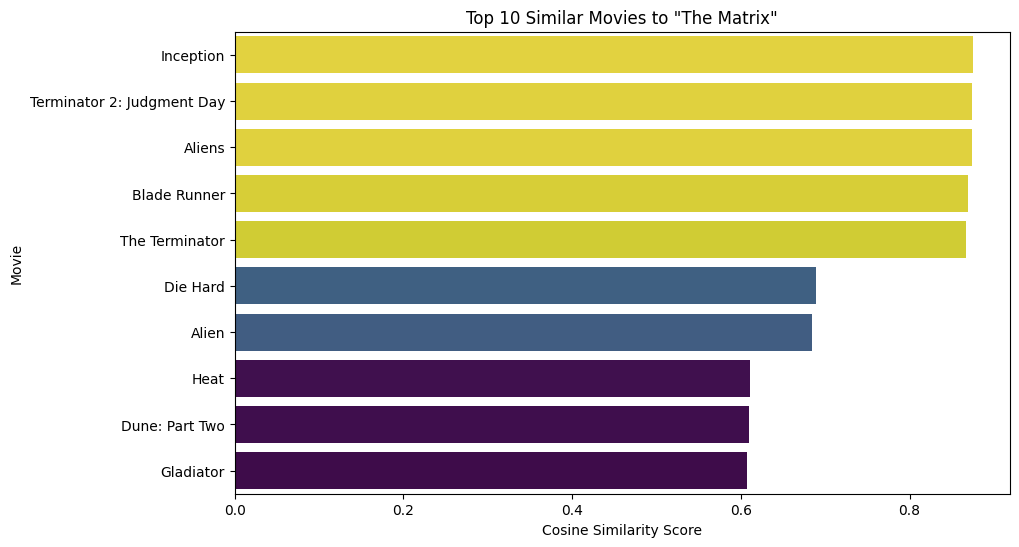

In [14]:
# Extract similarity scores for the movie
similarities = cosine_sim_df[movie_name].sort_values(ascending=False)[1:11]  # Top 10, excluding itself

# Plot similarity scores as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=similarities.values, y=similarities.index, hue=similarities.values, palette='viridis', legend=False)
plt.title(f'Top 10 Similar Movies to \"{movie_name}\"')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Movie')
plt.show()


#### Distribution of Movie Durations

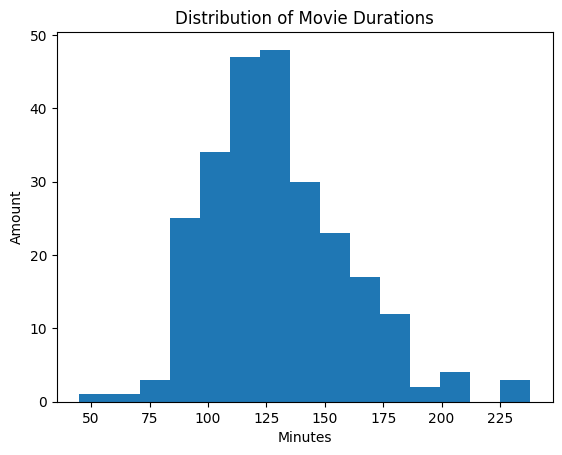

In [15]:
# using square root as this is simple and useful for general purposes
num_bins = int(np.sqrt(len(df['Duration_in_minutes'])))

# plot the histogram with the calculated number of bins
plt.hist(df['Duration_in_minutes'], bins=num_bins)

plt.title('Distribution of Movie Durations')
plt.xlabel('Minutes')
plt.ylabel('Amount')
plt.show()


#### Genre Analysis

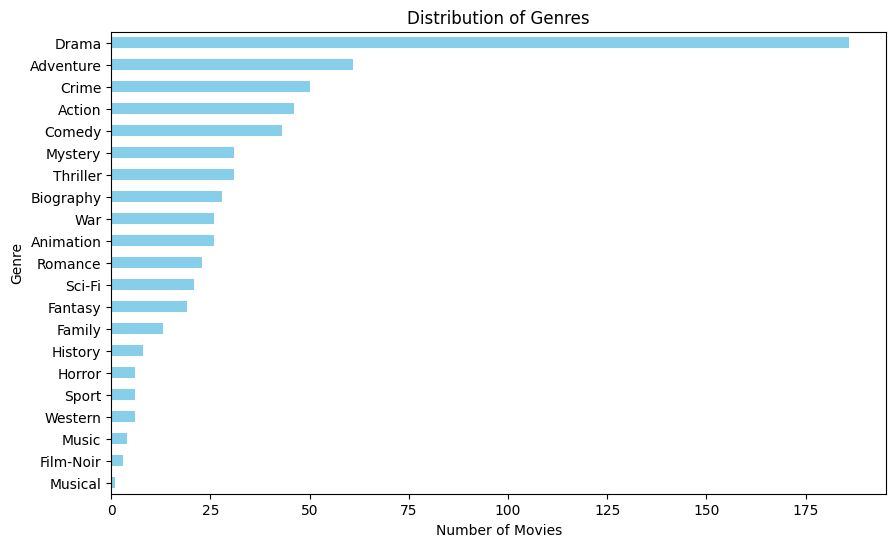

In [16]:
# Get the genre counts and sort them in descending order
genre_counts = df['Genre'].str.split(', ').explode().value_counts().sort_values(ascending=True)

# Plot the horizontal bar chart with sorted values
genre_counts.plot(kind='barh', figsize=(10, 6), color='skyblue')

# Add titles and labels
plt.title('Distribution of Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


#### Coverage Metrics

##### Interpreting the Results:
- High Coverage (>70%):
Recommendations span most movies in the dataset.
The system provides diverse suggestions rather than favoring a few movies.

- Low Coverage (<40%):
The system focuses on a small set of movies, indicating a bias.
May need more features or weight adjustments for better coverage.

In [17]:
# Function to calculate coverage
def calculate_coverage(top_n=10):
    recommended_movies = set()  # Store unique recommendations
    
    # Generate recommendations for each movie
    for movie in cosine_sim_df.index:
        top_recommendations = cosine_sim_df[movie].sort_values(ascending=False)[1:top_n+1]  # Exclude itself
        recommended_movies.update(top_recommendations.index)  # Add recommended movies
    
    # Calculate coverage percentage
    coverage = len(recommended_movies) / len(cosine_sim_df) * 100
    return coverage

# Calculate coverage for Top 10 recommendations
coverage = calculate_coverage(top_n=10)
print(f'Coverage: {coverage:.2f}%')


Coverage: 98.80%


### Diversity Metrics

##### Interpreting the Results:
- Diversity > 0.6:
The system is highly diverse, suggesting that it explores different genres and styles effectively.

- Diversity 0.4–0.6:
Moderate diversity, meaning it’s somewhat varied but still has clusters of similar movies.

- Diversity < 0.4:
The system has low diversity and may be overfitting to certain features like genre or duration.

In [18]:
def calculate_overall_diversity():
    # Flatten the similarity matrix, ignoring self-similarity (diagonal)
    similarity_values = cosine_sim_df.values[np.triu_indices_from(cosine_sim_df, k=1)]
    
    # Calculate average similarity across all pairs
    avg_similarity = np.mean(similarity_values)
    
    # Diversity is 1 - average similarity
    diversity_score = 1 - avg_similarity
    return diversity_score

# Calculate diversity for the entire dataset
diversity = calculate_overall_diversity()
print(f'Diversity (Overall): {diversity:.4f}')


Diversity (Overall): 0.6830


### Serendipity Testing

#### How is it Measured?
We use **Jaccard Similarity** to compare the **genres** of a movie with its recommendations:

- **Low Scores** = **Unexpected suggestions (a.k.a. Hidden Gems)** (serendipitous).
- **High Scores** = **Expected suggestions** (similar).


In [19]:
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

def serendipity_test(top_n=10):
    # Get recommendations
    recommendations = cosine_sim_df[movie_name].sort_values(ascending=False)[1:top_n+1]

    # Extract genres for the input movie
    input_genres = set(df[df['Name'] == movie_name]['Genre'].values[0].split(', '))

    # Analyze genre overlap using Jaccard similarity
    serendipity_scores = []
    for rec in recommendations.index:
        rec_genres = set(df[df['Name'] == rec]['Genre'].values[0].split(', '))
        score = jaccard_similarity(input_genres, rec_genres)
        serendipity_scores.append({'Movie': rec, 'Jaccard Similarity': score})

    # Create DataFrame and sort by lowest similarity (most serendipitous)
    serendipity_df = pd.DataFrame(serendipity_scores).sort_values(by='Jaccard Similarity', ascending=True)
    return serendipity_df

serendipity_results = serendipity_test(top_n=10)
print(serendipity_results)


                        Movie  Jaccard Similarity
7                        Heat            0.250000
8              Dune: Part Two            0.250000
9                   Gladiator            0.250000
5                    Die Hard            0.333333
6                       Alien            0.333333
2                      Aliens            0.666667
3                Blade Runner            0.666667
0                   Inception            0.666667
4              The Terminator            0.666667
1  Terminator 2: Judgment Day            0.666667
